<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>

# Machine Learning Foundation

## Course 3, Part f: Boosting and Stacking LAB

Estimated time needed: **45** minutes

## Objectives

After completing this demo you will be able to:

*   Understand how Gradient Boosting helps reduce error
*   Identify the benefits of using AdaBoost
*   Interpret the benefits of stacking models and comparing their results to boosted models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#Q1">Question 1</a></li>
        <li><a href="https://#Q2">Question 2</a></li>
        <li><a href="https://#Q3">Question 3</a></li>
        <li><a href="https://#Q4">Question 4</a></li>
        <li><a href="https://#Q5">Question 5</a></li>
        <li><a href="https://#Q6">Question 6</a></li>
</div>
<br>
<hr>


## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML241ENSkillsNetwork31576874-2022-01-01) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided:

*   Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
*   Triaxial angular velocity from the gyroscope.
*   A 561-feature vector with time and frequency domain variables.
*   Its activity label.

More information about the features is available on the website shown above.


In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import seaborn as sns, pandas as pd, numpy as np

In [2]:
import xgboost as xgb

<h2 id="Q1">Question 1</h2>

*   Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
*   Determine if the float columns need to be scaled.


In [3]:
### BEGIN SOLUTION
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/Human_Activity_Recognition_Using_Smartphones_Data.csv", sep=',')

The data has quite a few predictor columns.


In [4]:
data.shape

(10299, 562)

And they're all float values. The only non-float is the categories column, which is being predicted.


In [5]:
data.dtypes.value_counts()

,count
float64,561
object,1


The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.


In [6]:
# Mask to select float columns
float_columns = (data.dtypes == float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )
### END SOLUTION

True
True


<h2 id="Q2">Question 2</h2>

*   Integer encode the activities.
*   Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.


In [7]:
### BEGIN SOLUTION
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [8]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

In [9]:
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
count,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,...,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000,10299.000000
mean,0.274347,-0.017743,-0.108925,-0.607784,-0.510191,-0.613064,-0.633593,-0.525697,-0.614989,-0.466732,...,-0.298592,-0.617700,0.007705,0.002648,0.017683,-0.009219,-0.496522,0.063255,-0.054284,2.339936
std,0.067628,0.037128,0.053033,0.438694,0.500240,0.403657,0.413333,0.484201,0.399034,0.538707,...,0.320199,0.308796,0.336591,0.447364,0.616188,0.484770,0.511158,0.305468,0.268898,1.695529
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.262625,-0.024902,-0.121019,-0.992360,-0.976990,-0.979137,-0.993293,-0.977017,-0.979064,-0.935788,...,-0.536174,-0.841847,-0.124694,-0.287031,-0.493108,-0.389041,-0.817288,0.002151,-0.131880,1.000000
50%,0.277174,-0.017162,-0.108596,-0.943030,-0.835032,-0.850773,-0.948244,-0.843670,-0.845068,-0.874825,...,-0.335160,-0.703402,0.008146,0.007668,0.017192,-0.007186,-0.715631,0.182028,-0.003882,2.000000
75%,0.288354,-0.010625,-0.097589,-0.250293,-0.057336,-0.278737,-0.302033,-0.087405,-0.288149,-0.014641,...,-0.113167,-0.487981,0.149005,0.291490,0.536137,0.365996,-0.521503,0.250790,0.102970,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1)
memory usage: 44.2 MB


In [11]:
data = data.iloc[:4000]

In [12]:
data.shape

(4000, 562)

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.


In [13]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42)


In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape
### END SOLUTION

((2800, 561), (2800,), (1200, 561), (1200,))

In [15]:
X_train.info

<bound method DataFrame.info of       tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
3215           0.206508          -0.039241          -0.101176   
3126           0.276276          -0.018741          -0.100759   
697            0.275434          -0.030908          -0.120722   
3613           0.280212          -0.009867          -0.107093   
2374           0.316057          -0.003699          -0.258795   
...                 ...                ...                ...   
1130           0.257380          -0.115213          -0.186153   
1294           0.301401          -0.005687          -0.093504   
860            0.280475          -0.018976          -0.113756   
3507           0.281083          -0.013856          -0.114890   
3174           0.238147          -0.012122          -0.132434   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
3215         -0.399147         -0.188371         -0.033506         -0.444653   
3126         -0.996082         -0.994469         -0.981772         -0.996717   
697          -0.989864         -0.807848         -0.890871         -0.991318   
3613         -0.998098         -0.975032         -0.976572         -0.998732   
2374         -0.269575          0.302254          0.772267         -0.302969   
...                ...               ...               ...               ...   
1130         -0.076126          0.146512         -0.375180         -0.188595   
1294         -0.029313          0.202177         -0.346313         -0.086518   
860          -0.994825         -0.985314         -0.965857         -0.995170   
3507         -0.989299         -0.973738         -0.955450         -0.988964   
3174         -0.377790         -0.379369         -0.056556         -0.372175   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
3215         -0.224285         -0.105721         -0.250516  ...   
3126         -0.993907         -0.980107         -0.935294  ...   
697          -0.838340         -0.899343         -0.928835  ...   
3613         -0.974574         -0.977402         -0.939657  ...   
2374          0.348458          0.629220         -0.104537  ...   
...                ...               ...               ...  ...   
1130          0.145216         -0.352805          0.229528  ...   
1294          0.172274         -0.358566          0.446875  ...   
860          -0.984285         -0.963293         -0.937503  ...   
3507         -0.970588         -0.948153         -0.934996  ...   
3174         -0.413726         -0.018758         -0.396446  ...   

      fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
3215                         0.242476                        -0.579556   
3126                         0.546675                        -0.844439   
697                         -0.409059                        -0.078106   
3613                         0.225041                        -0.512340   
2374                         0.270318                        -0.523593   
...                               ...                              ...   
1130                         0.029390                         0.501995   
1294                         0.096177                         0.284249   
860                          0.539885                        -0.889671   
3507                         0.065957                        -0.499443   
3174                         0.293285                        -0.239194   

      fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
3215                        -0.884702                     0.686720   
3126                        -0.978993                    -0.024821   
697                         -0.475698                     0.084578   
3613                        -0.828512                     0.064333   
2374                        -0.854463                    -0.361388   
...                               ...                          ...   
1130                         0.312694     

<h2 id="Q3">Question 3</h2>

*   Fit gradient boosted tree models with all parameters set to their defaults with the following tree numbers (`n_estimators = [15, 25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models.
*   Plot the accuracy as a function of estimator number.

*Note:* there is no out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.


In [16]:
### BEGIN SOLUTION
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200]
for n_trees in tree_list:

    # Initialize the gradient boost classifier
    GBC = xgb.XGBClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)

    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees
Fitting model with 25 trees
Fitting model with 50 trees
Fitting model with 100 trees
Fitting model with 200 trees


,error
n_trees,
15.0,0.016667
25.0,0.011667
50.0,0.009167
100.0,0.008333
200.0,0.008333


Now plot the result.


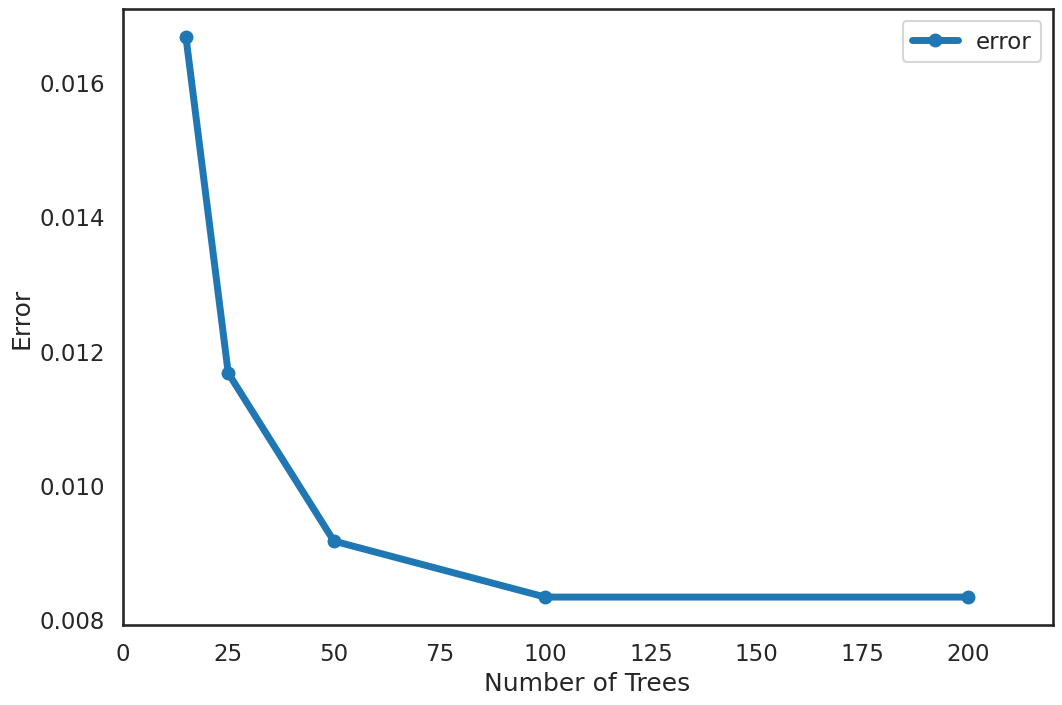

In [17]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);
### END SOLUTION

<h2 id="Q4">Question 4</h2>

*   Using a grid search with cross-validation, fit a new gradient boosted classifier with the same list of estimators as question 3. Also try varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
*   Examine the parameters of the best fit model.
*   Calculate relevant error metrics on this model and examine the confusion matrix.


In [18]:
### BEGIN SOLUTION
warnings.warn("once")
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [2, 4]}

# The grid search object
GV_GBC = GridSearchCV(xgb.XGBClassifier(random_state=42),
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=4)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [19]:
# The best model
GV_GBC.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_features=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

The error metrics. Classification report is particularly convenient for multi-class cases.


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.97      0.96      0.96       203
           2       0.96      0.98      0.97       232
           3       0.99      0.99      0.99       194
           4       0.99      1.00      1.00       193
           5       0.99      0.98      0.98       164

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.


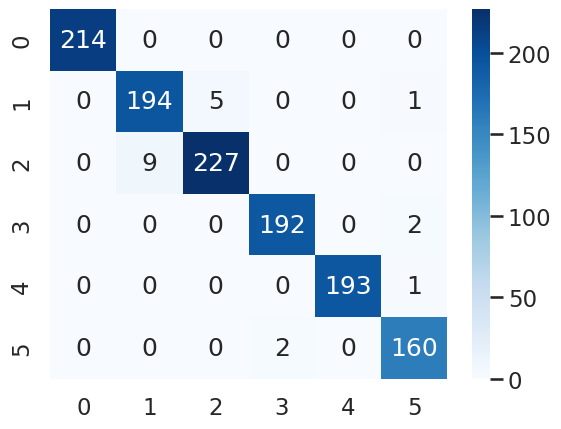

In [21]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

<h2 id="Q5">Question 5</h2>

*   Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
*   Compare the errors from AdaBoost to those from the GradientBoostedClassifier.


In [23]:
### BEGIN SOLUTION
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid,
                      scoring='accuracy',
                      n_jobs=-1,
                      verbose=4)

GV_ABC = GV_ABC.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


The best model.


In [24]:
# The best model
GV_ABC.best_estimator_

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.01, n_estimators=100)

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.


In [25]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.00      0.00      0.00         0
           2       1.00      0.54      0.70       436
           3       1.00      0.35      0.52       550
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.54      1200
   macro avg       0.50      0.32      0.37      1200
weighted avg       1.00      0.54      0.67      1200



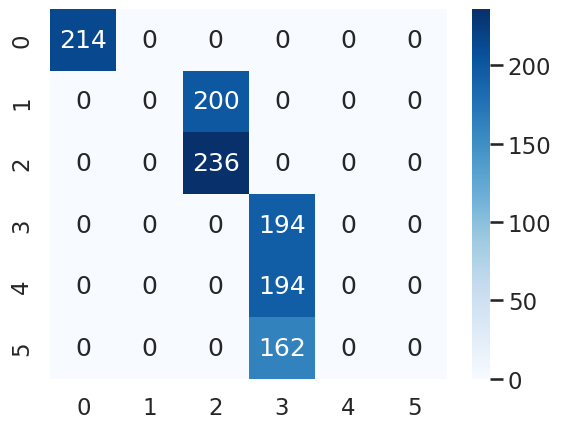

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

<h2 id="Q6">Question 6</h2>

*   Fit a logistic regression model with regularization.
*   Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
*   Determine the error as before and compare the results to the appropriate gradient boosted model(s).
*   Plot the confusion matrix for the best model created in this set of exercises.


In [27]:
### BEGIN SOLUTION
from sklearn.linear_model import LogisticRegression

# L2 regularized logistic regression
LR_L2 = LogisticRegression(penalty='l2', max_iter=500, solver='saga').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.


In [28]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.95      0.95      0.95       200
           2       0.96      0.96      0.96       236
           3       1.00      0.98      0.99       197
           4       1.00      0.99      1.00       195
           5       0.98      1.00      0.99       158

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200



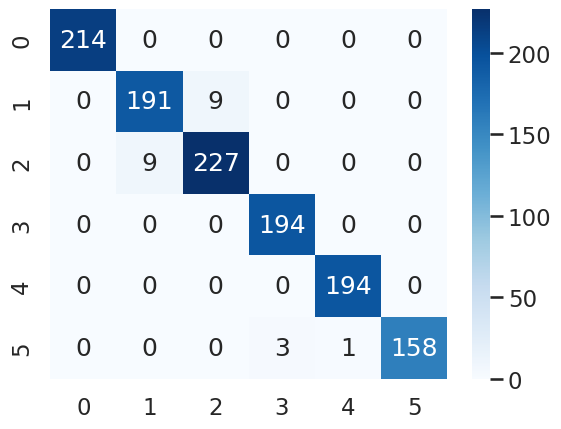

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()

And now the stacked model.


In [30]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Performance for the voting classifier should improve relative to either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder to try the simplest model first. In some cases, its performance will be good enough.


In [31]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       0.96      0.95      0.96       200
           2       0.96      0.97      0.96       236
           3       1.00      1.00      1.00       194
           4       1.00      1.00      1.00       194
           5       1.00      1.00      1.00       162

    accuracy                           0.99      1200
   macro avg       0.99      0.99      0.99      1200
weighted avg       0.99      0.99      0.99      1200



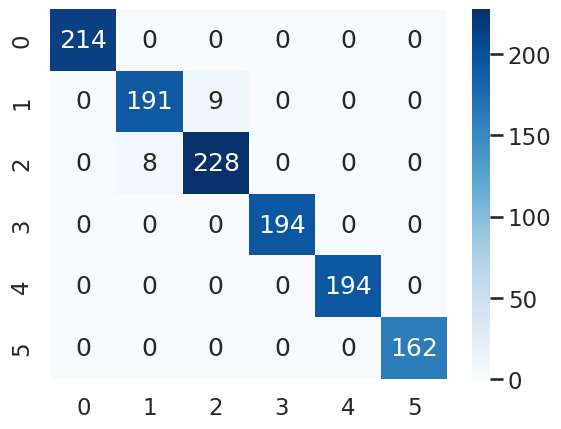

In [32]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.show()
#sns.set_context('talk')
#cm = confusion_matrix(y_test, y_pred)
#ax = sns.heatmap(cm, annot=True, fmt='d')
### END SOLUTION

***

### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

### Other Contributors

<a href="https://www.linkedin.com/in/richard-ye/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Richard Ye</a>

## <h3 align="center"> Machine Learning Foundation (C) 2020 IBM Corporation </h3>

<!--## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description |
| ----------------- | ------- | ---------- | ------------------ |
| 2022-03-23        | 0.1     | Joseph Santarcangelo | Created Lab Template |
| 2022-05-03        | 0.2     | Richard Ye | Added in estimated time, objectives and table of contents |--!>


